In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('../DATA/RSCCASN.csv', parse_dates=True, index_col='DATE')

In [8]:
df.columns = ['Sales']

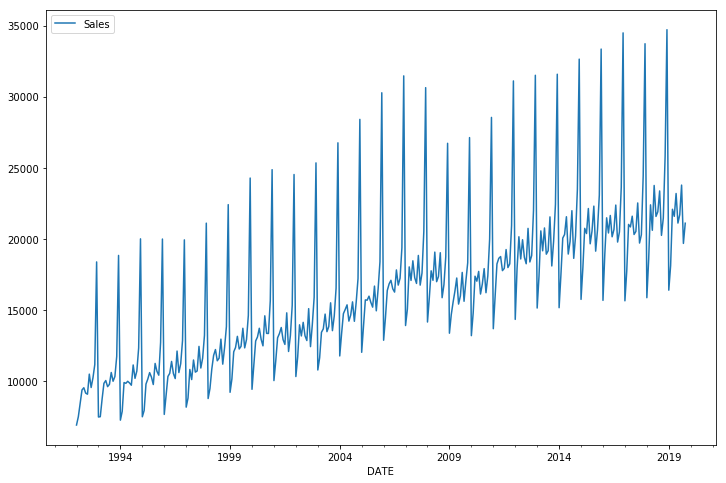

In [9]:
df.plot(figsize=(12,8))

In [12]:
len(df) - 18

316

In [13]:
test_size = 18
test_ind = len(df) - test_size

In [14]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [19]:
scaler.fit(train)

/usr/local/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [20]:
scaled_train = scaler.transform(train)

In [21]:
scaled_test = scaler.transform(test)

In [22]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
len(test)

18

In [24]:
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length, batch_size=1)

In [25]:
X, y = generator[0]

In [34]:
len(X[0])

12

In [35]:
from tensorflow.keras.models import Sequential

In [36]:
from tensorflow.keras.layers import Dense, LSTM

In [37]:
n_features = 1

In [38]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [40]:
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [42]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [43]:
model.fit_generator(generator, epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0272 - val_loss: 0.0033
Epoch 2/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0181 - val_loss: 0.0028
Epoch 3/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0086 - val_loss: 0.0253
Epoch 4/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0073 - val_loss: 0.0047


In [44]:
losses = pd.DataFrame(model.history.history)

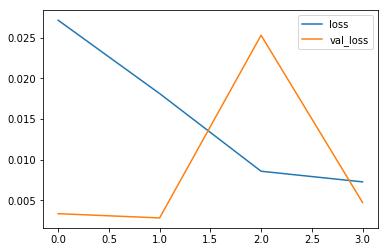

In [45]:
losses.plot()

In [46]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    # prediction 1 timestamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred)
    
    # update batch to include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

In [47]:
true_predictions = scaler.inverse_transform(test_predictions)

In [48]:
test['Predictions'] = true_predictions

/usr/local/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22752.729796
2018-06-01,21589,21912.843159
2018-07-01,21919,22143.605945
2018-08-01,23381,23619.741432
2018-09-01,20260,21733.898940
2018-10-01,21473,22524.900818
2018-11-01,25831,26964.577896
2018-12-01,34706,34651.819371
2019-01-01,16410,19354.177724


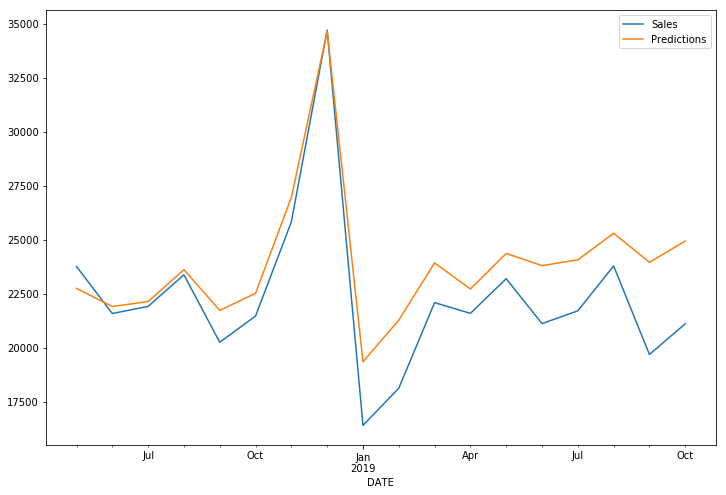

In [50]:
test.plot(figsize=(12,8))

In [51]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

/usr/local/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [52]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                               length=length,batch_size=1)

In [54]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator, epochs=3)

Epoch 1/3
322/322 [==============================] - 1s 5ms/step - loss: 0.0249
Epoch 2/3
322/322 [==============================] - 1s 5ms/step - loss: 0.0172
Epoch 3/3
322/322 [==============================] - 1s 4ms/step - loss: 0.0079


In [56]:
forecast = []
periods = 12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    # prediction 1 timestamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred)
    
    # update batch to include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

In [57]:
forecast = scaler.inverse_transform(forecast)

In [59]:
forecast

array([[24880.83060932],
       [23735.5866189 ],
       [24184.46414518],
       [26575.8097744 ],
       [23861.57618141],
       [24901.19816399],
       [35454.54663086],
       [50958.74099255],
       [21875.36856604],
       [24398.83897877],
       [28468.37523413],
       [27094.35497618]])

In [60]:
forecast_index = pd.date_range(start='2019-11-01', periods=periods,
                              freq="MS")

In [61]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [62]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index,
                          columns=['Forecast'])

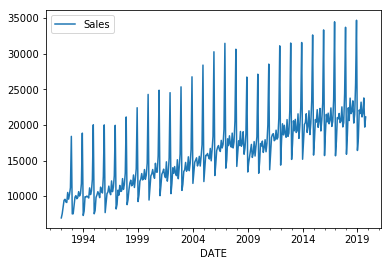

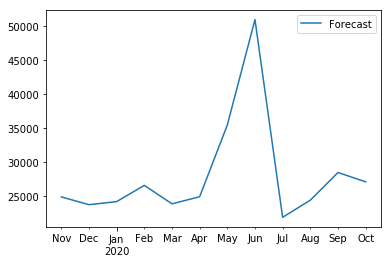

In [64]:
df.plot()
forecast_df.plot()

(576, 611)

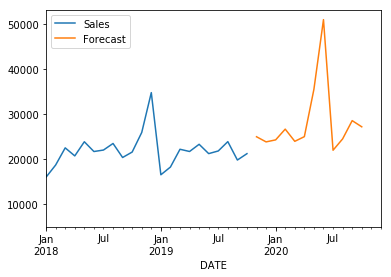

In [66]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01', '2020-12-01')